# Introduction

# Upload File (Google Colab)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving churn.csv to churn.csv


# Setup

In [4]:
# Install causalml
!pip install causalml

     |████████████████████████████████| 401 kB 5.2 MB/s 
     |████████████████████████████████| 326 kB 46.7 MB/s 
     |████████████████████████████████| 1.8 MB 51.1 MB/s 
     |████████████████████████████████| 713 kB 45.0 MB/s 
  Created wheel for causalml: filename=causalml-0.12.1-cp37-cp37m-linux_x86_64.whl size=1036195 sha256=5c5e06e736412495788cfdd9b3b1992d27e0b2da46f81bddadbb96b2ccf1c0f5
  Stored in directory: /root/.cache/pip/wheels/c2/a7/ff/f853b7e4d8d4d9b68df70333a06d6a01fd96fb086e2922ace1
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465089 sha256=473fcfa0a1cc4e03467918f1bfd628d8b4c545e8fb915aeb4b112df4b594769f
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [5]:
# Import Files
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Data

In [6]:
# Read file
df = pd.read_csv('churn.csv')

In [7]:
# See shape
df.shape

(2666, 20)

In [8]:
# View head
df.head()

,State,Area_code,Account_length,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,International_plan,Voice_mail_plan,Number_vmail_messages,Customer_service_calls,Churn
0,KS,415,128,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,No,Yes,25,1,False
1,OH,415,107,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,No,Yes,26,1,False
2,NJ,415,137,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,No,No,0,0,False
3,OH,408,84,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,Yes,No,0,2,False
4,OK,415,75,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,Yes,No,0,3,False


In [ ]:
# Select relevant columns
#df = df[['GenderID', 'Salary', 'PositionID', 'DeptID', 'PerfScoreID', 'MarriedID', 'FromDiversityJobFairID', 'ManagerID', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences']]
#df = df.dropna()
#df.shape

In [9]:
df = pd.get_dummies(df)
df = pd.get_dummies(df, columns=['Churn'])
df = df.drop(['Churn_False'], 1)
df

,Area_code,Account_length,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Number_vmail_messages,Customer_service_calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,International_plan_No,International_plan_Yes,Voice_mail_plan_No,Voice_mail_plan_Yes,Churn_True
0,415,128,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,415,107,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,415,137,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,408,84,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,415,75,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,415,79,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2662,415,192,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,36,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2663,415,68,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2664,510,28,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [10]:
df = df.dropna()

In [ ]:
# df = df[df['TotalCharges'] != " "]

# Identify Features

In [11]:
# Identify Target
y = df['Churn_True']
y

0       0
1       0
2       0
3       0
4       0
       ..
2661    0
2662    0
2663    0
2664    0
2665    0
Name: Churn_True, Length: 2641, dtype: uint8

In [12]:
# Identify Treatment Feature
treatment = df['Customer_service_calls']
pd.Series(treatment).value_counts()

1    936
2    604
0    552
3    341
4    132
5     48
6     17
7      8
9      2
8      1
Name: Customer_service_calls, dtype: int64

In [13]:
# Identify Control Features
#X = df[['gender', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines']]
X = df.drop(['Churn_True', 'Customer_service_calls'], 1)
#X['TotalCharges'] = pd.to_numeric(X['TotalCharges'])

# Uplift Tree Classifier: Customer_service_calls (Binary)


In [14]:
from causalml.inference.tree import UpliftTreeClassifier
from causalml.inference.tree import UpliftRandomForestClassifier

In [15]:
# Set customer service calls to binary
df.loc[df['Customer_service_calls'] > 0, 'Customer_service_calls'] = 'any_service_calls'
df.loc[df['Customer_service_calls'] != 'any_service_calls', 'Customer_service_calls'] = 'no_service_calls'
df

,Area_code,Account_length,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Number_vmail_messages,Customer_service_calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,International_plan_No,International_plan_Yes,Voice_mail_plan_No,Voice_mail_plan_Yes,Churn_True
0,415,128,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,25,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,415,107,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,26,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,415,137,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,408,84,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,415,75,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,415,79,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2662,415,192,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,36,any_service_calls,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2663,415,68,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2664,510,28,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [17]:
df_train['Churn_True'] = df_train['Churn_True'].astype(np.int)
df_train['Customer_service_calls'] = df_train['Customer_service_calls'].astype(np.str)


In [18]:
clf = UpliftTreeClassifier(control_name='no_service_calls')
clf.fit(df_train[X.columns].values,
         treatment=df_train['Customer_service_calls'].values,
         y=df_train['Churn_True'].values)
p = clf.predict(df_test[X.columns].values)

In [19]:
df_res = pd.DataFrame(p, columns=clf.classes_)
df_res.head()

,no_service_calls,any_service_calls
0,0.022508,0.081395
1,0.022508,0.081395
2,0.571429,0.487805
3,0.312500,0.276667
4,0.558824,0.356164


In [80]:
df_res.count()

no_service_calls           529
any_service_calls          529
recommended_treatment      529
delta_any_service_calls    529
max_delta                  529
dtype: int64

In [20]:
uplift_model = UpliftRandomForestClassifier(control_name='no_service_calls')


In [21]:
uplift_model.fit(df_train[X.columns].values,
                 treatment=df_train['Customer_service_calls'].values,
                 y=df_train['Churn_True'].values)

In [22]:
df_res = uplift_model.predict(df_test[X.columns].values, full_output=True)
print(df_res.shape)
df_res.head()

(529, 5)


,no_service_calls,any_service_calls,recommended_treatment,delta_any_service_calls,max_delta
0,0.061921,0.123439,1,0.061519,0.061519
1,0.081316,0.100300,1,0.018984,0.018984
2,0.413757,0.289835,0,-0.123922,-0.123922
3,0.175213,0.182695,1,0.007482,0.007482
4,0.489455,0.312642,0,-0.176813,-0.176813


In [23]:
y_pred = uplift_model.predict(df_test[X.columns].values)


In [24]:
y_pred.shape

(529, 1)

In [25]:
# Put the predictions to a DataFrame for a neater presentation
# The output of `predict()` is a numpy array with the shape of [n_sample, n_treatment] excluding the
# predictions for the control group.
result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])
result.head()

,any_service_calls
0,0.061519
1,0.018984
2,-0.123922
3,0.007482
4,-0.176813


In [26]:
result.mean()

any_service_calls    0.011411
dtype: float64

# Uplift Curve: Customer_service_calls (Binary)



In [27]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((result < 0).all(axis=1),
                           'control',
                           result.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test['Customer_service_calls'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['Customer_service_calls'] == 'no_service_calls', 1, 0)

In [28]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

Calculate the observed treatment effect per predicted treatment effect quantile

In [29]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             churn = df_test.loc[synthetic, 'Churn_True'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))

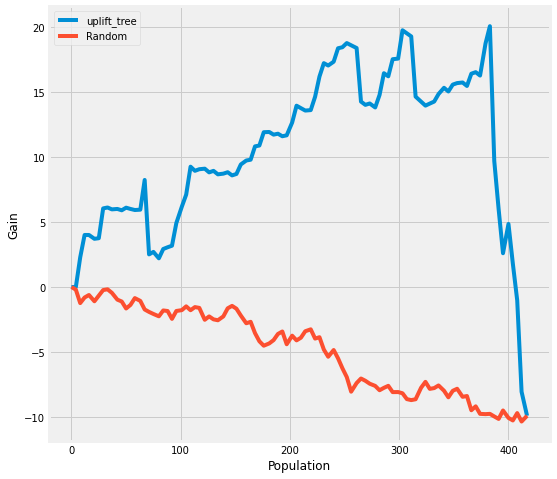

In [30]:
plot_gain(auuc_metrics, outcome_col='churn', treatment_col='is_treated')

# Uplift Tree Classifier: Customer_service_calls (Buckets)

In [31]:
df['Customer_service_calls'].value_counts()

any_service_calls    2089
no_service_calls      552
Name: Customer_service_calls, dtype: int64

In [32]:
# Set customer service calls to binary
df['Customer_service_calls'] = df['Customer_service_calls'].replace([0],'no_service_calls')
df['Customer_service_calls'] = df['Customer_service_calls'].replace([1,2,3],'1_to_3_service_calls')
df['Customer_service_calls'] = df['Customer_service_calls'].replace([4,5,6,7,8,9],'4_to_9_service_calls')
#df['Customer_service_calls'] = df['Customer_service_calls'].replace([7,8,9],'7_to_9_service_calls')
df

,Area_code,Account_length,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Number_vmail_messages,Customer_service_calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,International_plan_No,International_plan_Yes,Voice_mail_plan_No,Voice_mail_plan_Yes,Churn_True
0,415,128,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,25,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,415,107,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,26,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,415,137,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,408,84,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,415,75,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,415,79,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2662,415,192,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,36,any_service_calls,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2663,415,68,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2664,510,28,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [33]:
df['Customer_service_calls'].value_counts()

any_service_calls    2089
no_service_calls      552
Name: Customer_service_calls, dtype: int64

In [34]:
from causalml.inference.tree import UpliftTreeClassifier

In [35]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [36]:
clf = UpliftTreeClassifier(control_name='no_service_calls')
clf.fit(df_train[X.columns].values,
         treatment=df_train['Customer_service_calls'].values,
         y=df_train['Churn_True'].values)
p = clf.predict(df_test[X.columns].values)

In [37]:
df_res = pd.DataFrame(p, columns=clf.classes_)
df_res.head()

,no_service_calls,any_service_calls
0,0.022508,0.081395
1,0.022508,0.081395
2,0.571429,0.487805
3,0.312500,0.276667
4,0.558824,0.356164


In [38]:
uplift_model = UpliftRandomForestClassifier(control_name='no_service_calls')


In [39]:
uplift_model.fit(df_train[X.columns].values,
                 treatment=df_train['Customer_service_calls'].values,
                 y=df_train['Churn_True'].values)

In [40]:
df_res = uplift_model.predict(df_test[X.columns].values, full_output=True)
print(df_res.shape)
df_res.head()

(529, 5)


,no_service_calls,any_service_calls,recommended_treatment,delta_any_service_calls,max_delta
0,0.034996,0.138011,1,0.103015,0.103015
1,0.166626,0.126979,0,-0.039647,-0.039647
2,0.105442,0.152218,1,0.046776,0.046776
3,0.187404,0.202183,1,0.014779,0.014779
4,0.183042,0.160685,0,-0.022357,-0.022357


In [41]:
y_pred = uplift_model.predict(df_test[X.columns].values)

In [42]:
y_pred.shape

(529, 1)

In [43]:
# Put the predictions to a DataFrame for a neater presentation
# The output of `predict()` is a numpy array with the shape of [n_sample, n_treatment] excluding the
# predictions for the control group.
result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])
result.head()

,any_service_calls
0,0.103015
1,-0.039647
2,0.046776
3,0.014779
4,-0.022357


In [44]:
result.mean()

any_service_calls   -0.002964
dtype: float64

# Uplift Curve: Customer_service_calls (Buckets)

In [45]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((result < 0).all(axis=1),
                           'control',
                           result.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test['Customer_service_calls'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['Customer_service_calls'] == 'no_service_calls', 1, 0)

In [46]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

Calculate the observed treatment effect per predicted treatment effect quantile

In [47]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             conversion = df_test.loc[synthetic, 'Churn_True'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))

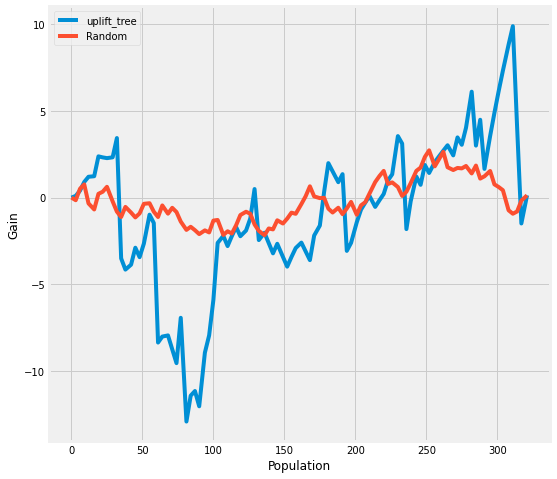

In [48]:
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

# Meta-Learner Feature Importances¶

In [49]:
feature_names= X.columns
feature_names 

Index(['Area_code', 'Account_length', 'Total_day_minutes', 'Total_day_calls',
       'Total_day_charge', 'Total_eve_minutes', 'Total_eve_calls',
       'Total_eve_charge', 'Total_night_minutes', 'Total_night_calls',
       'Total_night_charge', 'Total_intl_minutes', 'Total_intl_calls',
       'Total_intl_charge', 'Number_vmail_messages', 'State_AK', 'State_AL',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',
       'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV',
    

# S learner

In [81]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in treatment]) # customize treatment/control names

In [82]:
from lightgbm import LGBMRegressor

base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)
slearner_tau = slearner.fit_predict(X, w_multi, y)

# Feature Importance (method = auto)

In [87]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': Total_day_minutes      0.315405
 Total_eve_minutes      0.119228
 Total_night_calls      0.114827
 Total_eve_calls        0.076678
 Total_intl_calls       0.074911
                          ...   
 State_MN               0.000000
 State_NC               0.000000
 State_ND               0.000000
 State_NE               0.000000
 Voice_mail_plan_Yes    0.000000
 Length: 70, dtype: float64}

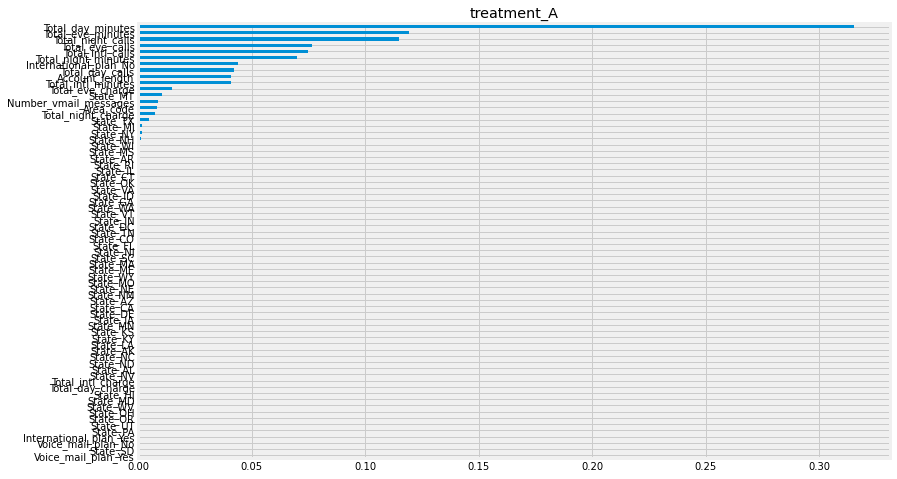

In [88]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

# Feature Importance (method = permutation)

In [89]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': Total_day_minutes    0.763196
 Total_night_calls    0.238239
 Total_eve_minutes    0.233306
 Total_intl_calls     0.215248
 Total_eve_calls      0.106864
                        ...   
 State_DE            -0.000032
 State_DC            -0.000108
 State_IA            -0.000237
 State_CO            -0.000241
 State_NV            -0.000406
 Length: 70, dtype: float64}

In [91]:
import time
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 5.354543924331665 seconds


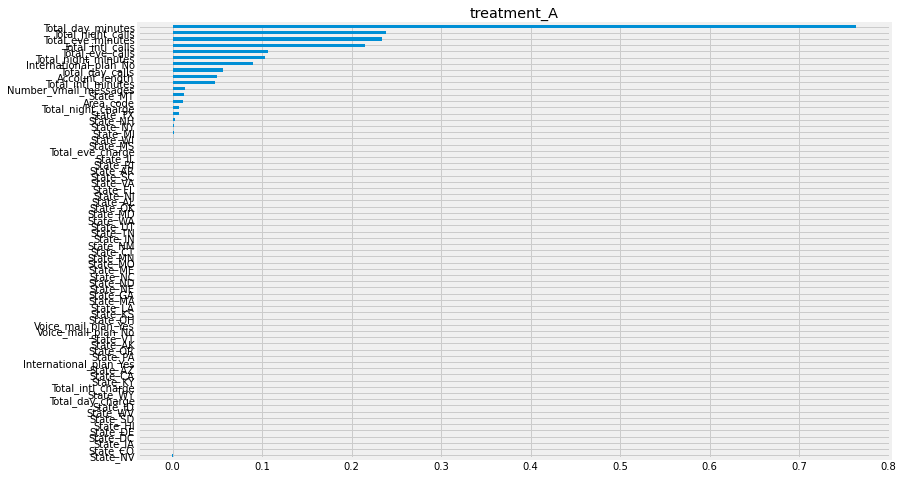

In [92]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

In [123]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor

slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)
slearner_tau = slearner.fit_predict(X, w_multi, y)

model_tau_feature = RandomForestRegressor()  # specify model for model_tau_feature

slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=feature_names)

{'treatment_A': Total_day_minutes    0.158575
 Total_day_charge     0.137654
 Total_night_calls    0.099155
 Total_eve_calls      0.075561
 Total_intl_calls     0.070828
                        ...   
 State_NC             0.000456
 State_IL             0.000429
 State_HI             0.000426
 State_VT             0.000385
 State_NE             0.000225
 Length: 70, dtype: float64}

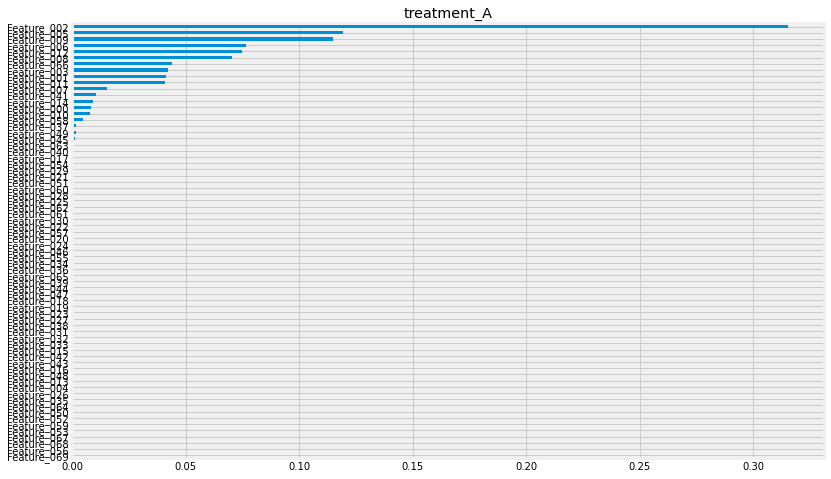

In [124]:
# Using the feature_importances_ method in the base learner (LGBMRegressor() in this example)
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='auto')

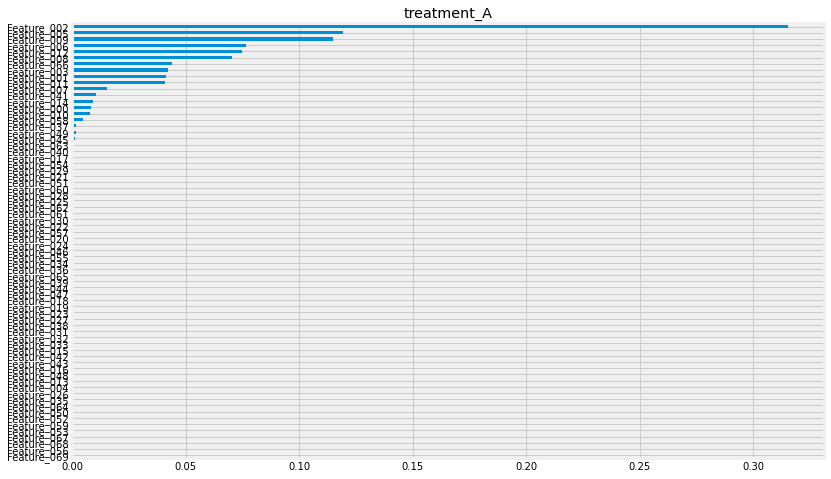

In [125]:
# Using the feature_importances_ method in the base learner (LGBMRegressor() in this example)
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='auto')

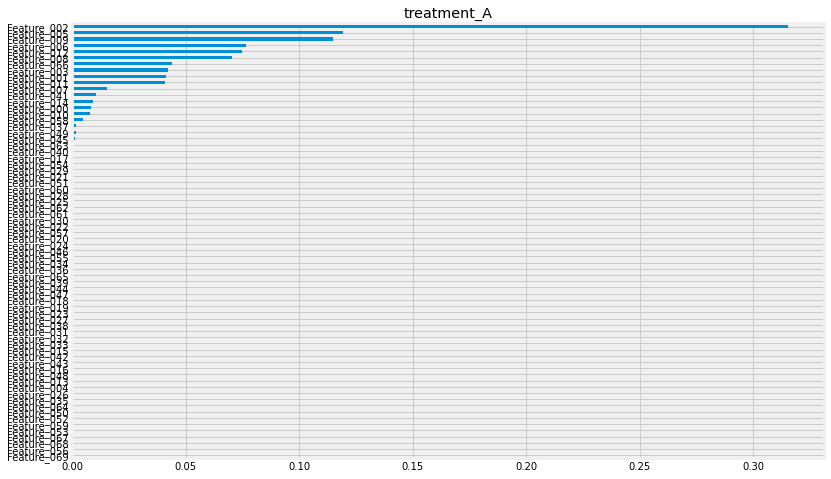

In [126]:
# Using the feature_importances_ method in the base learner (LGBMRegressor() in this example)
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='auto')

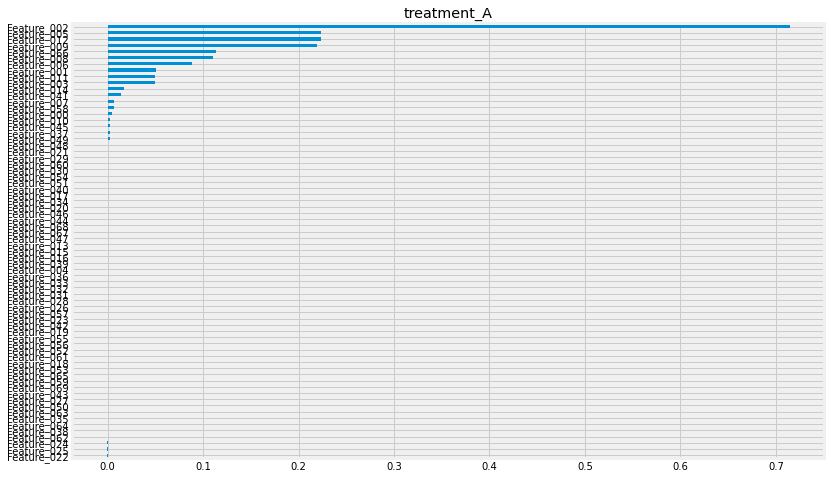

In [127]:
# Using eli5's PermutationImportance
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='permutation')

# SHAP Values

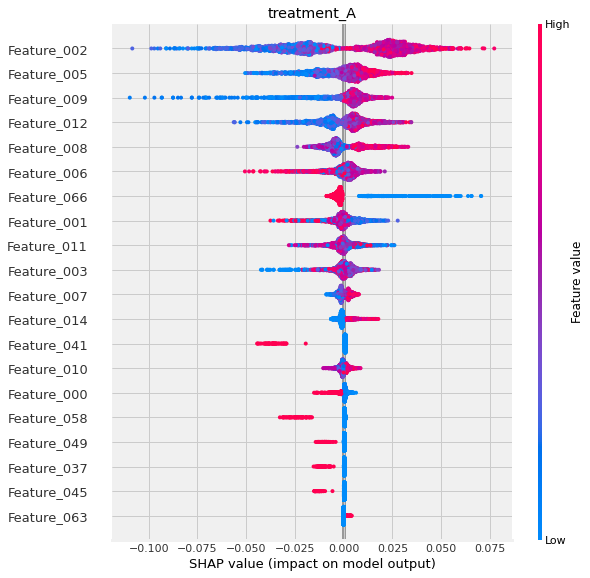

In [128]:
# Using SHAP
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau)

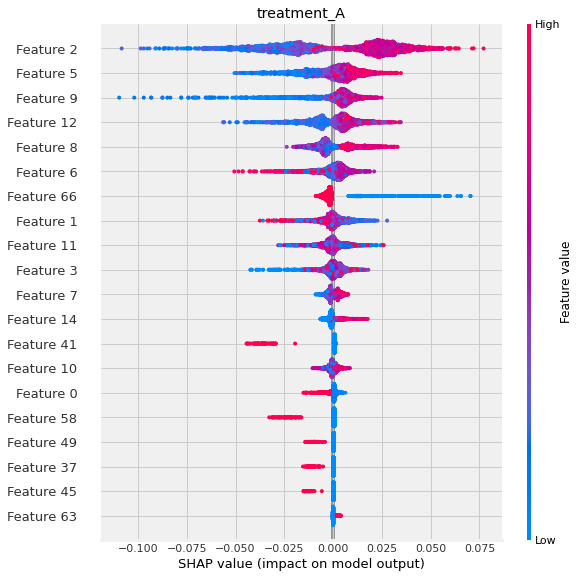

In [131]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

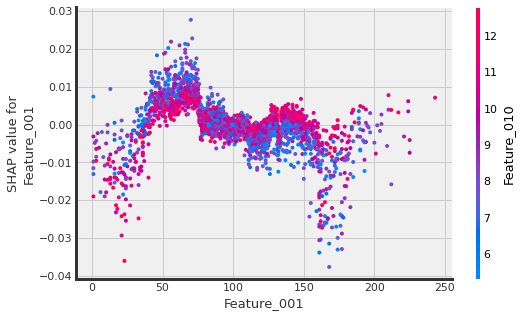

In [130]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                            feature_idx=1,
                            X=X,
                            tau=slearner_tau,
                            interaction_idx='auto')

# Uplift Tree Visualization

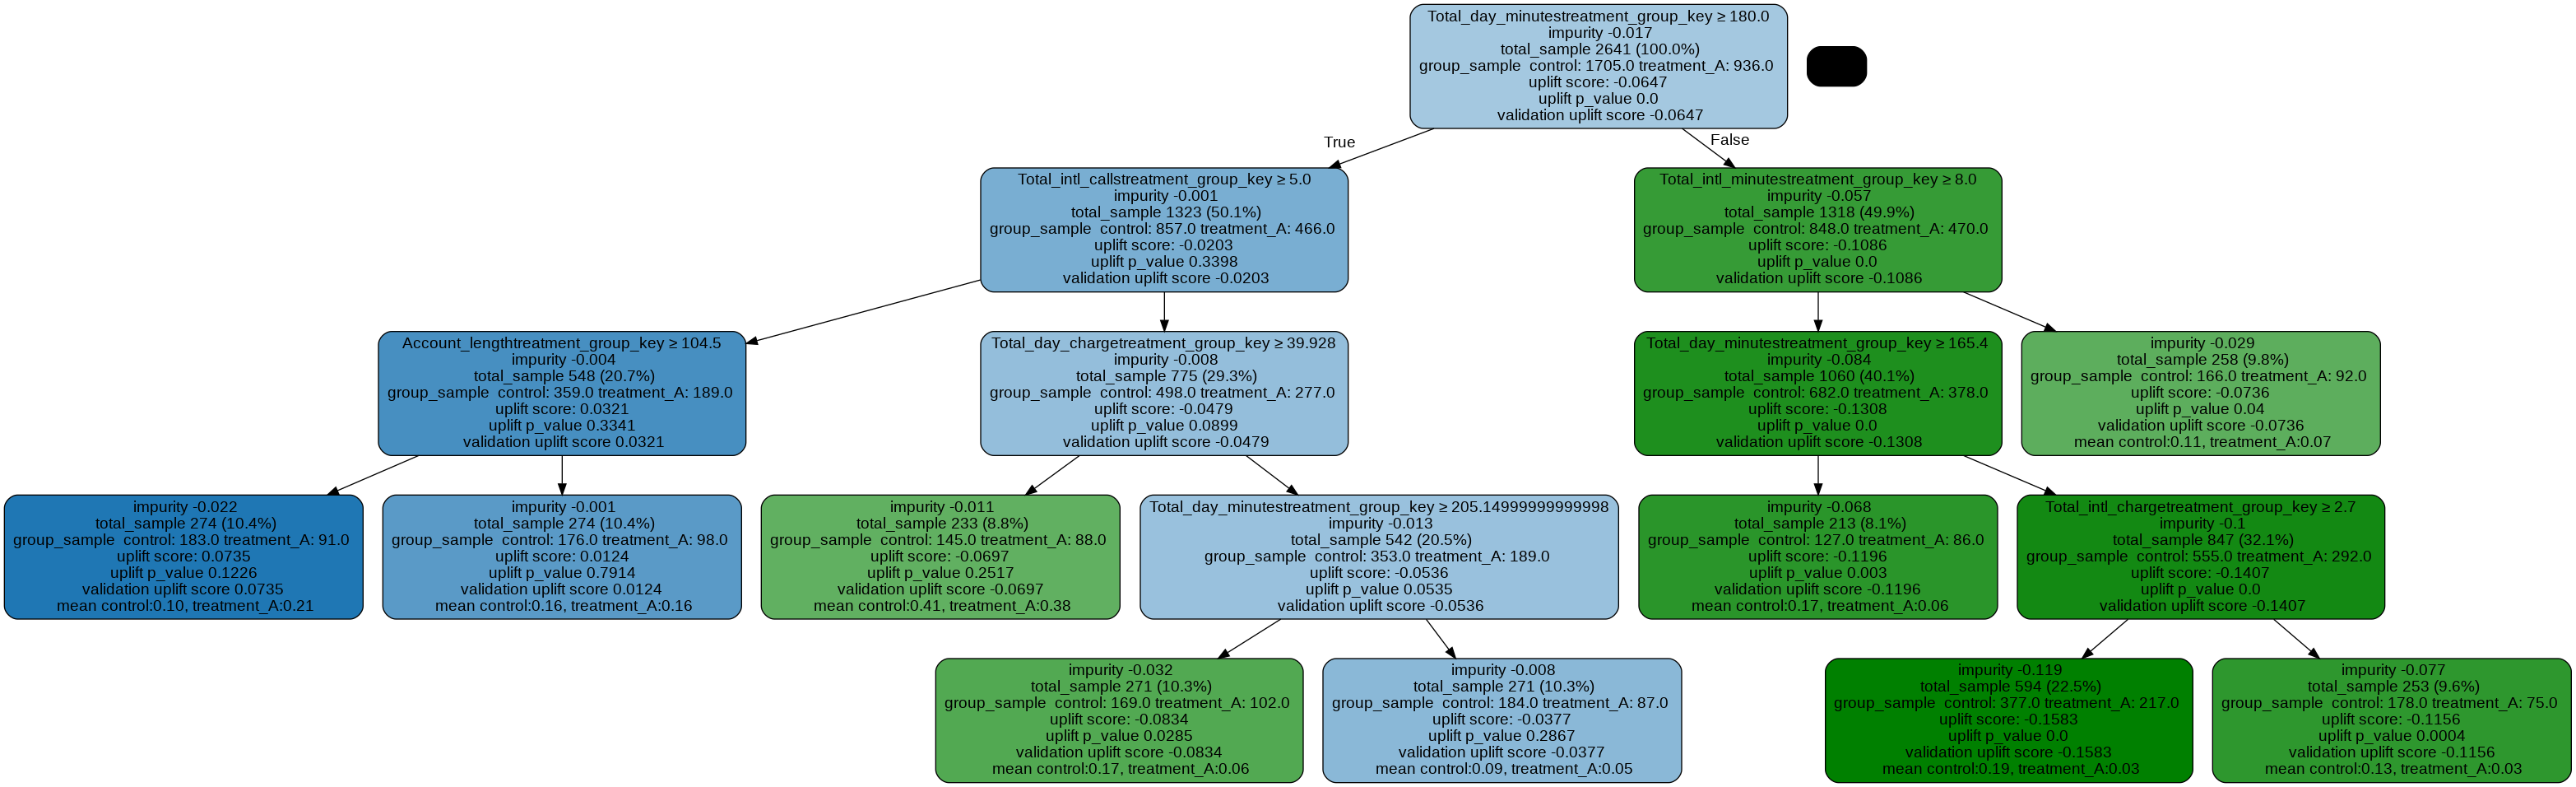

In [86]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X, w_multi, y)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, feature_names)
Image(graph.create_png())